<a href="https://colab.research.google.com/github/Dario66/Exam23-06-2022/blob/main/Exam_Dario_Grandi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scarico i 3 file csv di Train, Test e Validation da GitHub.

In [3]:
! git clone https://github.com/Dario66/Deep-Learning.git

! mv Deep-Learning/test_data.csv test_data.csv
! mv Deep-Learning/train_data.csv train_data.csv
! mv Deep-Learning/val_data.csv val_data.csv
! rm -rf Deep-Learning

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 272 (delta 11), reused 5 (delta 5), pack-reused 254
Receiving objects: 100% (272/272), 2.50 MiB | 9.19 MiB/s, done.
Resolving deltas: 100% (128/128), done.


importo le librerie necessarie


In [4]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding,Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D ,AveragePooling1D, LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from keras.callbacks import ModelCheckpoint
import string
import re
import nltk
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
import nltk
import unicodedata
! pip install emoji
import emoji
import itertools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


carico i 3 dataset in formato csv e unifico i file in un unico DataFrame, dal momento che effettuerò un refactor delle colonne in questo modo non dovrò ripetere le operazioni sui Set. Effetturò il partizionamento in un secondo momento.



There are 17348 rows and 7 columns for TRAIN

There are 3717 rows and 7 columns for TEST

There are 3718 rows and 7 columns for VALIDATION


tweet con più caratteri :754


numero di tweet con più di 500 caratteri :7




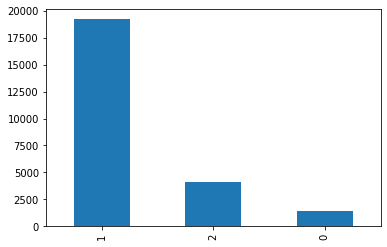

In [5]:
nRow, nCol = pd.read_csv("train_data.csv").shape
print('\nThere are {} rows and {} columns for TRAIN'.format(nRow, nCol))
nRow, nCol = pd.read_csv("test_data.csv").shape
print('\nThere are {} rows and {} columns for TEST'.format(nRow, nCol))
nRow, nCol = pd.read_csv("val_data.csv").shape
print('\nThere are {} rows and {} columns for VALIDATION\n\n'.format(nRow, nCol))

# merging csv files
df = pd.concat(
    map(pd.read_csv, ['train_data.csv', 'test_data.csv', 'val_data.csv']), ignore_index=True)

df['class'].value_counts().plot(kind='bar')


def findLen(str):
    counter = 0   
    for i in str:
        counter += 1
    return counter

max_lenght=0
count_over_500=0
for index, row in df.iterrows():
  testo = str(row['tweet'])
  ooo=findLen(testo)
  if ooo>max_lenght:
    max_lenght=len(testo)
  if ooo>400:
    count_over_500 += 1

print('tweet con più caratteri :'+str(max_lenght)+'\n\n')
print('numero di tweet con più di 500 caratteri :'+str(count_over_500)+'\n\n')

Dal grafico si può notare un forte sbilanciamento delle classi, è stato scelto di non utilizzare tecniche di Over/Under Sampling per evitare ulteriore overfit ma piuttosto la regolazione del parametro class_weight durante il training del modello.

Implemento le funzioni per il pre-processamento dei dati testuali, applicando sostituzioni e rimozioni sulla colonna contenente il tweet.

Saranno trattati i dati come URL,EMOJI,HASHTAG,SMILEY, ESCAPE, PUNCTUATIONS, CONTRACTIONS.



In [6]:
import collections
from collections import Counter
from nltk.corpus import stopwords
#metodi di clean https://towardsdatascience.com/twitter-sentiment-analysis-using-fasttext-9ccd04465597
stop_words = stopwords.words('english')
nltk.download('wordnet')
nltk.download('omw-1.4')

def stopwordsFilt(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  filtered_sentence = []
  for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
  return filtered_sentence

CONTRACTIONS = {"mayn't":"may not", "may've":"may have", "aren't":"are not", "can't":"can not", 
                "couldn't":"could not", "daren't":"dare not", "didn't":"did not", "doesn't":"does not", 
                "don't":"do not", "hasn't":"has not", "haven't":"have not", "hadn't":"had not", 
                "isn't":"is not", "mightn't":"might not", "mustn't":"must not", "needn't":"need not", 
                "oughtn't":"ought not", "shan't":"shall not", "shouldn't":"should not", "wasn't":"was not", 
                "weren't":"were not", "won't":"will not", "wouldn't":"would not"}

def remov_duplicates(input):
  
    # split input string separated by space
    input = input.split(" ")
  
    # now create dictionary using counter method
    # which will have strings as key and their 
    # frequencies as value
    UniqW = Counter(input)
  
    # joins two adjacent elements in iterable way
    s = " ".join(UniqW.keys())
    return s
  
lemmatizer = WordNetLemmatizer() 

def contractors_fix(text):
   text = text.replace("’","'")
   words = text.split()
   reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
   text = " ".join(reformed)
   return text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text
def clean_text(text):
    text = str(text).lower()
    text = contractors_fix(text)
    text = emoji.demojize(text, delimiters=("", ""))#traduzione Emoji
    text=  remove_accented_chars(text)#rimuove caratteri accentati
    text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", text).split())#Rimozione punteggiatura
    text = re.sub('\[.*?\]', '', text)#Rimozione punteggiatura
    text = re.sub('https?://\S+|www\.\S+', '', text)#Rimozione Url
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
    text = re.sub('<.*?>+', '', text)#Rimozione Html tag
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)#rimuove i punti di inizio e fine discorso
    text = re.sub('\n', '', text)#rimuove le righe vuote
    text = re.sub('\w*\d\w*', '', text)#Regular Expressions
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))#Correzzione parole errate
    text = re.sub("(.)\\1{2,}", "\\1", text)
    text = re.sub(' +', ' ',text)
    text = remov_duplicates(text)
    text = re.sub(r"http", "", text)
    text = re.sub(r"jkw", "", text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = [word for word in text.split(' ') if word not in stop_words]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]#Rimuove gli affissi
    text=" ".join(text)
    return text

#Modifico testo da ogni tweet
for index, row in df.iterrows():
    df.at[index, 'tweet'] = remove_accented_chars(clean_text(row['tweet']))
   

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Stampo il numero di righe e colonne del Dataset unificato

In [7]:
nRow, nCol = df.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 24783 rows and 7 columns


Per comodità rinomino le colonne tweet e class in text e category, aggiungendo una colonna ulteriore con le 3 possibili classi di appartenenza--> 0: hate_speech, 1 offensive_language, 2: neither. 

Creo un nuovo dataframe prendendo le due colonne rinominate e inserendo la colonna aggiuntiva, in modo da avere 3 colonne: text, category e label.


In [8]:
c=df['class']
df.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df['text']
b=df['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)
df

,text,category,label
0,get money silli hoe,offensive_language,1
1,almost year ago gave bitch away stolen,offensive_language,1
2,rakwonogod bitch tweet last night gt like some...,offensive_language,1
3,hoe fat trel said best,offensive_language,1
4,charli crist pull one rick scott well floridap...,neither,2
...,...,...,...
24778,hoe amp,offensive_language,1
24779,fake niggah lolol,offensive_language,1
24780,got nigga bitch,offensive_language,1
24781,gotta understand bitch childish,offensive_language,1


Conto quanti record per ciascuna classe di appartenenza

In [9]:
# Grouping data by label
df['category'].value_counts()

offensive_language    19190
neither                4163
hate_speech            1430
Name: category, dtype: int64

In [10]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



Procedo a creare i dataset di Train,Test e Validation attraverso il metodo train_test_split di sklearn e successivamente rinomino le etichette dei set.


In [11]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.15,
    random_state=42,
    stratify=df.label.values,    
)

X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.15,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

df.head



<bound method NDFrame.head of                                                     text            category  \
0                                    get money silli hoe  offensive_language   
1                 almost year ago gave bitch away stolen  offensive_language   
2      rakwonogod bitch tweet last night gt like some...  offensive_language   
3                                 hoe fat trel said best  offensive_language   
4      charli crist pull one rick scott well floridap...             neither   
...                                                  ...                 ...   
24778                                            hoe amp  offensive_language   
24779                                  fake niggah lolol  offensive_language   
24780                                    got nigga bitch  offensive_language   
24781                    gotta understand bitch childish  offensive_language   
24782  your retard hope get type diabet die sugar rus...         hate_speech   

       la

Mostro a schermo i raggruppamenti dei DataSet

In [12]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test         214
                         train       1034
                         val          182
neither            2     test         625
                         train       3007
                         val          531
offensive_language 1     test        2879
                         train      13864
                         val         2447

compongo i set di Train,Test e Validation concatenando il primo e l'ultimo in un unica variabile

In [13]:
df_train = df.loc[df["data_type"]=="train"]
df_val = df.loc[df["data_type"]=="val"]
df_test = df.loc[df["data_type"]=="test"]

df_train.head()

df_train_plus_val = pd.concat([df_train,df_val], axis=0)
df_train_plus_val.head()

#print(df_train_plus_val.groupby(['label']).count())
print(df_train_plus_val['category'].value_counts())

offensive_language    16311
neither                3538
hate_speech            1216
Name: category, dtype: int64


Scarico l'embedded GloVe e mantengo solo il file che mi interessa glove.6B.100d.txt

In [14]:
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip glove*.zip
! ls
! pwd

! rm glove.6B.200d.txt
! rm glove.6B.300d.txt
! rm glove.6B.50d.txt
! rm -rf glove.6B.zip

--2022-06-30 14:09:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-30 14:09:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-30 14:09:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Creo un oggetto Tokenizer e creo l'indice del vocabolario in base alla frequenza delle parole, assegnandogli un numero unico intero.

Procedo a trasformare ogni testo in una sequenza di numeri interi, ogni parola nel testo viene sostituita col il valore intero corrispondente considerando il dizionario utilizzato.
 

In [15]:
x = df_train_plus_val.text.values
y = df_train_plus_val.label.values

max_features = 10000
max_text_length = 500

x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

x_test_tokenized = x_tokenizer.texts_to_sequences(df_test.text.values)
x_test = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

Codifico i tweet utilizzando la funzione to_categorical() e li converto in numeri, in modo tale che tweet simili finiscano per avere numeri simili. 

Trovo le singole parole nel tweet e mappo le parole in numeri unici, i tweet con parole in comune avranno numeri simili per quella parte della sequenza.

Mi avvalgo di un vocabolario esistente (GloVo) e inizializzo lo strato Embedding con i vettori GloVe preaddestrati.

Procedo quindi a scaricare GloVe embedding. Leggo questi embedding in un dizionario per consultarli quando andrò a creare la matrice da incorporare al modello.
Il layer conterrà il mapping per le parole in vettori GloVe.


In [16]:
embedding_dim =100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')




embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

y_train_plus_val =  tf.keras.utils.to_categorical(y, num_classes=3)
y_test =  tf.keras.utils.to_categorical(df_test.label, num_classes=3)
y_train_plus_val

embedding_layer = Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False)

Found 400000 word vectors


Procedo a costruire il modello di Rete Neurale Convoluzionale, applico strati di Conv1D e MaxPooling1D per la ricerca delle feature


In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(64,2,padding='same',activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.4))
model.add(Conv1D(32,2,padding='same',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32,2,padding='same',activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         1000000   
                                                                 
 conv1d_44 (Conv1D)          (None, None, 64)          12864     
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, None, 64)          0         
                                                                 
 conv1d_45 (Conv1D)          (None, None, 32)          4128      
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, None, 32)         0         
 g1D)                                                

In [ ]:
import math

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight


# random labels_dict
labels_dict = {0: 214, 1: 2879, 2: 625}

labels_dictV2 = {0: 1216, 1: 16311, 2: 3538}

Procedo alla compilazione e fit del modello creando un checkpoint del modello per salvare gli eventuali risultati migliorativi. Come fuzione di perdita utilizzo Categorical CrossEntropy poichè le classi da predire sono > 2. Il validation split è impostato a 15% per mantenere le stesse dimensione dei file iniziali.

Dal momento che il nostro dataset è completamento sbilanciato il comportamento del training evidenzia un po di underfitting

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

earlyStopping = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(x_train_val, y_train_plus_val, batch_size= 32, validation_split=0.15, class_weight=create_class_weight(labels_dictV2), epochs=8, callbacks=[checkpointer,earlyStopping])



Epoch 1/8
560/560 [==============================] - 38s 66ms/step - loss: 0.4908 - accuracy: 0.8199 - val_loss: 0.3509 - val_accuracy: 0.8604
Epoch 2/8
560/560 [==============================] - 38s 69ms/step - loss: 0.3778 - accuracy: 0.8605 - val_loss: 0.3269 - val_accuracy: 0.8696
Epoch 3/8
560/560 [==============================] - 37s 66ms/step - loss: 0.3532 - accuracy: 0.8698 - val_loss: 0.3142 - val_accuracy: 0.8835
Epoch 4/8
560/560 [==============================] - 38s 67ms/step - loss: 0.3351 - accuracy: 0.8750 - val_loss: 0.3065 - val_accuracy: 0.8829
Epoch 5/8
560/560 [==============================] - 37s 66ms/step - loss: 0.3233 - accuracy: 0.8828 - val_loss: 0.3061 - val_accuracy: 0.8842
Epoch 6/8
560/560 [==============================] - 38s 68ms/step - loss: 0.3144 - accuracy: 0.8840 - val_loss: 0.2978 - val_accuracy: 0.8845
Epoch 7/8
560/560 [==============================] - 37s 66ms/step - loss: 0.3038 - accuracy: 0.8894 - val_loss: 0.2985 - val_accuracy: 0.8908

Compongo il grafico rappresentante l'andamento della loss e accuracy function.

Dal grafico si vede che inizialmente si ha una situazione di underfitting, con il passare degli epoche, alla n°6 le linee si intersecano con un incremento costante di overfitting questo puo esser dovuto al rumore presente sui dati, lo sbilanciamento delle classi a disposizione e dimensioni diverse del testo del tweet.

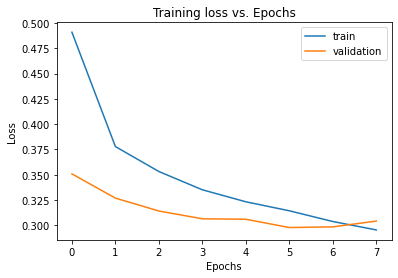

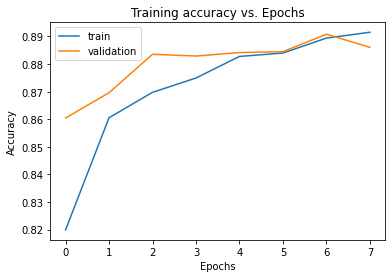

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

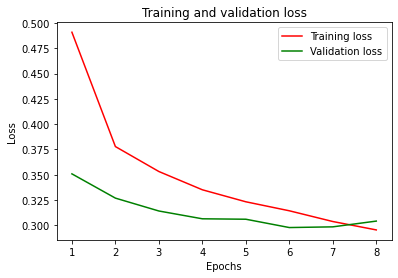

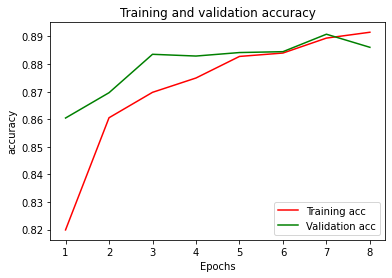

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Valuto il modello addestrato su i dati di Test.

In [ ]:
eval_hist=model.evaluate(x_test,y_test, batch_size = 32)


117/117 [==============================] - 3s 22ms/step - loss: 0.3244 - accuracy: 0.8776


In [ ]:
y_pred = model.predict(x_test)
print(y_pred)
y_pred = np.array( [ np.argmax (y) for y in y_pred ] )
print(y_pred)

[[1.70613255e-03 5.68276830e-03 9.92611110e-01]
 [8.84960592e-02 9.04824376e-01 6.67950418e-03]
 [8.19261000e-02 9.17967558e-01 1.06388645e-04]
 ...
 [5.95554151e-02 1.42313167e-01 7.98131347e-01]
 [1.65704582e-02 9.83211458e-01 2.18046363e-04]
 [2.49931496e-02 9.74518776e-01 4.87995247e-04]]
[2 1 1 ... 2 1 1]


Costruisco la matrice di confusione multiclasse in modo da capire quanto potrebbe essere lontana una previsione quando le classi di output sono ordinali.

La sola indicazione della accuracy non cia aiuta a valutare bene il modello poichè non sappiamo come vengono distribuite le probabilità.
Per una maggiore comprensione creo la matrice di confusione.

Gli elementi diagonali della matrice di confusione rappresentano il numero di punti per i quali l'etichetta prevista è uguale all'etichetta vera, mentre gli elementi fuori diagonale sono quelli etichettati erroneamente dal  classificatore, si puo vedere come la predizioni siano accettabili per due classi (1,2) mentre risulta insufficente per la classe 0 la quale ha predetto troppo pochi campioni rispetto alle altre.



number of sample: 3718


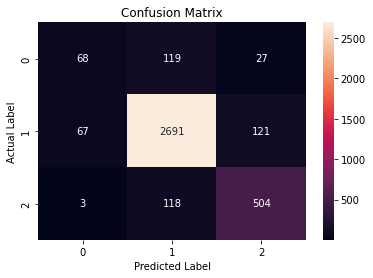

In [ ]:
from sklearn.metrics import plot_confusion_matrix

y_test_labels = df_test.label
print('number of sample: '+str(len(y_test_labels)))
cm = confusion_matrix(y_test_labels, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)


y_test_labels

model.save('model.h5')

Dalla matrice sopra notiamo che su 214 campioni solo 68 sono stati classificati correttamente
Mentre per le altre due label (1,2) su un totale di 2.879(1) e 625(2) si ha una predizione positiva 2691(1) e (504).
Le label 2 e 1 sarebbero anche accettabili se non fosse per la label 0.

Normalizzo la matrice per leggere la percentuale dei campioni classificati.

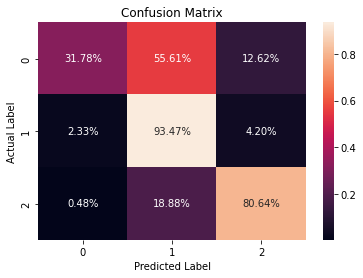

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = sns.heatmap(cmn, annot=True, fmt=".2%")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)






Utilizzo le api di skliearn per generare il report di classificazione risultante

Tenendo presente che: 
La precision indica quante del numero totale di previsioni specificate come positive sono state assegnate correttamente. 
La recall è il numero totale di casi positivi effettivi previsti correttamente.
F1 combina precision e recall in una media armonica dei due valori.
solitamente per avere un buon risultato si dovrebbe aevere precision, recall e f1 identica, questo ci 

Per le micro e macro avg (per qualsiasi metrica) l'interpretazione differisce. Una macroavg calcolerà la metrica in modo indipendente per ogni classe e poi ne farà la media (trattando quindi tutte le classi allo stesso modo), mentre una micromedia aggregherà i contributi di tutte le classi per calcolare la metrica media. In una configurazione di classificazione multiclasse, la micromedia è preferibile se si sospetta che ci sia uno squilibrio tra le classi (ad esempio, si possono avere molti più esempi di una classe che di altre). 


In [ ]:

from sklearn.metrics import classification_report
from sklearn import metrics
print(metrics.classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.32      0.39       214
           1       0.92      0.93      0.93      2879
           2       0.77      0.81      0.79       625

    accuracy                           0.88      3718
   macro avg       0.73      0.69      0.70      3718
weighted avg       0.87      0.88      0.87      3718



**Conclusioni**


Il calcolo rivela che una valutazione efficace della qualità di un modello richiede più contesto rispetto al valore di accuratezza, infatti comparando il training di vari modelli provati , vi sono modelli che posso avere una precisione di accurattezza maggiore ma che hanno però uno sbilanciamento di predizione sulle classi predette piu marcato,
infatti non conta quanto sia piu alta una previsione in se ma conta in rapporto alle altre.
KLe tre predizioni dovrebbero esser simili e non discostarsi molto tra loro.

La situazione ideale dovrebbe esser rappresentata da numeri di precision, recall e f1 praticamente uguali o alemno molto simili, nel nostro caso variano, per la classe 1 e 2 non si discostano di molto invece per la label 0 si ha un discostamento piu importante.

Nel caso della metrica "accuracy"(micro avg) la media 0.88 è l'unica che vediamo su f1-score perchè il report di classificazione deve visualizzare un solo valore di accuratezza, visto che precision e recall hanno lo stesso valore.


Lavorando con un set di dati sbilanciato in cui tutte le classi sono ugualmente importanti, l'uso della macro-avg è la scelta che privilegio, poiché tratta tutte le classi allo stesso modo.

Sono stati fatti molti test sulla rete modificando i prametri e layer del modello per trovare la soluzione che garantisse i risultati migliori, ovviamente è stato tenuto conto del fatto che il numero di prametri sarebbe dovuto esser non troppo elevato, riportando qui gli ultimi 6 test come esempio swi puo notare come l'accuracy e loss non siano attendibili come unico parametro di valutazaione:



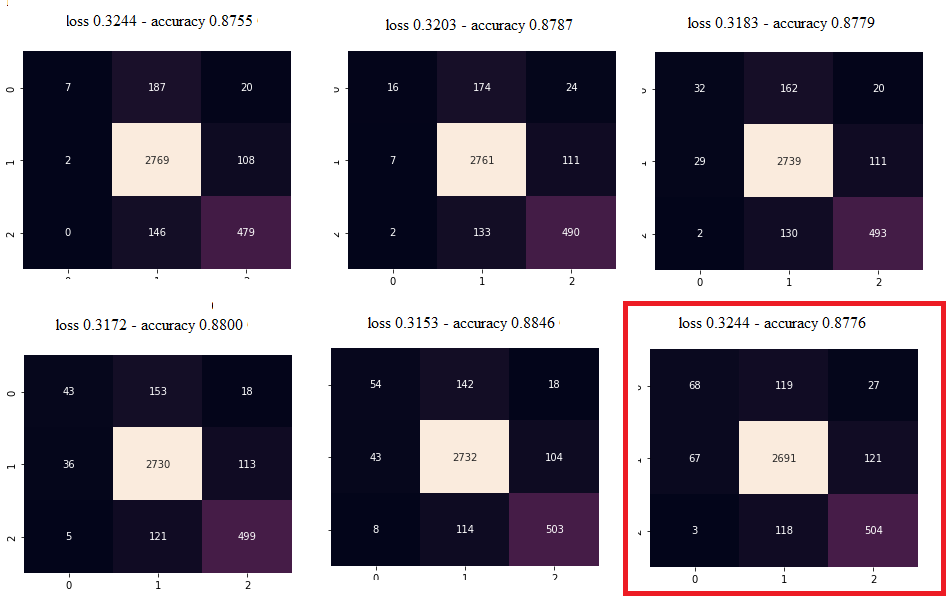



Come possibili soluzione migliorative, se non si vuole provare a regolare i parametri attualmente usati, sia per la rete che per la pre-elaborazione del testo, si potrebbe incrementare il numero di sampling del dataset aggiungendo altri sample con classi uguali e che possano esser generati casualmente da quelli preesistenti, oppure effettuare entrambe oversampling e Undersampling cercando di gestire i dati affinchè vi siano un numero maggiori di istanze per la classe 0 e 2 e meno istanze per la classe dominante 1.
Questo porterebbe ad avere un incremento significativo del rumore da dover poi gestire.
 Una parte decisamente importante è stata la preelaborazione dei dati testuali, effettuare una pulizia e un refactor del test più preciso e attendo puo aumetare il grado di precisione per le 3 classi sulla matrice di confusione.
